In [15]:
# %% Import Libraries
#This is a test
import os
import pickle
import scipy.io
import numpy as np
import pandas as pd
import torch as tc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split

import ruptures as rpt
from scipy.stats import zscore

import matplotlib.patches as mpatches
from tqdm import tqdm
from bptt.models import Model
import model_anafunctions as func

plt.rcParams['font.size'] = 20

# Individual example of Change points in behaviour data

Chosen model is clipped shPLRNN, the bases Parameter has no effect here!


100%|██████████| 55/55 [00:06<00:00,  9.15it/s]


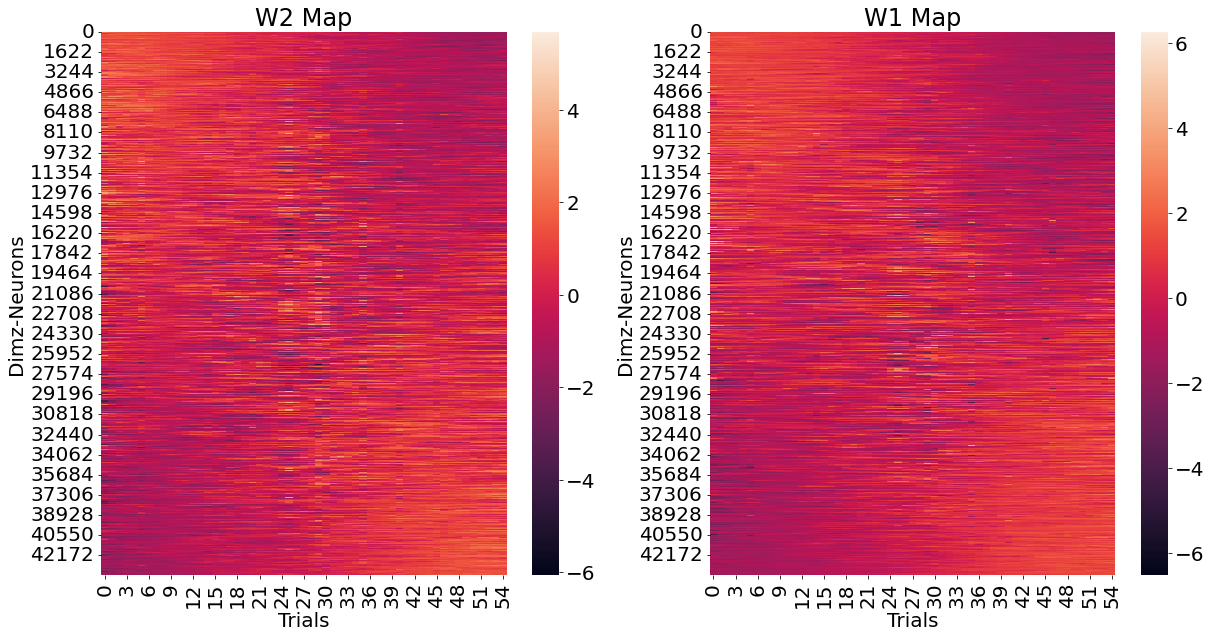

In [18]:
data_path = 'D:\\_work_cestarellas\\Analysis\\Pack_Daniel_project\\Preprocess_model\\bptt_CE17\\neuralactivity\\datasets' 
# Select Path for Models (Folder containing the specific models to test)
model_path = 'D:/_work_cestarellas/Analysis/Pack_Daniel_project/Preprocess_model/bptt_CE17/results'

#%% Loading models and simulations
model_name = 'DataTrainingH768_lm1_1e-05_lm2_128_lm3_00_seql_400/001'
mpath=os.path.join(model_path,model_name).replace('\\','/')


train_n,train_i = func.load_data(data_path,'Training')
test_n,test_i = func.load_data(data_path,'Test')
NeuronPattern={"Training_Neuron":train_n,"Training_Input":train_i,
               "Testing_Neuron":test_n,"Testing_Input":test_i}

# Loading Metadata info
file=open(os.path.join(data_path,'Metadata.pkl'),'rb')
Metadata_info=pickle.load(file)
file.close()

# Load Model
num_epochs = 150000
m = Model()
m.init_from_model_path(mpath, epoch=num_epochs)
m.eval()
# Generation Training Data
ModelS=[]
for w_index in tqdm(range(len(NeuronPattern["Training_Neuron"]))):
    data_trial=tc.from_numpy(NeuronPattern["Training_Neuron"][w_index]).float()          # tensor of neuronal data for initial trial data
    input_trial = tc.from_numpy(NeuronPattern["Training_Input"][w_index]).float()
    length_sim = input_trial.shape[0]
    X, _ = m.generate_free_trajectory(data_trial,input_trial,length_sim,w_index)
    ModelS.append(X[:,:])
Model_Signal,_=func.concatenate_list(ModelS,0)
Train_Signal,_=func.concatenate_list(train_n,0)

_, W1t, W2t, _, _, _ = m.get_latent_parameters()
# Transform tensor to numpy format
W2 = W2t.detach().numpy().transpose(1,2,0)
W1 = W1t.detach().numpy().transpose(1,2,0)

# Parameters
HU=W2.shape[1]                      # Number hidden units
Neurons=W2.shape[0]                 # Number Neurons
Trials=W2.shape[2]                  # Number Trials

# W2 Matrix
W2_np = W2
mat=W2_np
mat=mat.reshape(-1,mat.shape[2])
mat=zscore(mat,axis=1)
sort_pos = func.sort_by_slope(mat)
mat=mat[sort_pos,:]

# W1 Matrix
W1_np = W1
mat1=W1_np
mat1=mat1.reshape(-1,mat1.shape[2])
mat1=zscore(mat1,axis=1)
sort_pos = func.sort_by_slope(mat1)
mat1=mat1[sort_pos,:]

# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
# Set font size for both plots
plt.rcParams['font.size'] = 20
# Plot heatmap for mat in the first subplot (left)
sns.heatmap(data=mat, ax=axes[0])
axes[0].set_title('W2 Map')
axes[0].set_xlabel('Trials')
axes[0].set_ylabel('Dimz-Neurons')
# Plot heatmap for mat1 in the second subplot (right)
sns.heatmap(data=mat1, ax=axes[1])
axes[1].set_title('W1 Map')
axes[1].set_xlabel('Trials')
axes[1].set_ylabel('Dimz-Neurons')
plt.show()


(43776, 55)

Text(0.5, 1.0, 'Session for modelling')

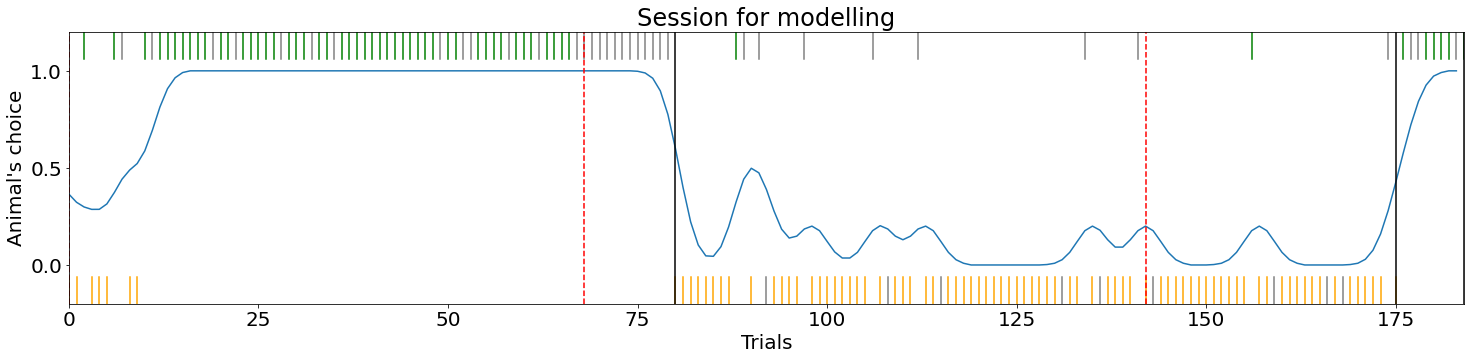

In [2]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% BEHAVIOUR %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
path_beh='D:/_work_cestarellas/Analysis/PLRNN/Session_Selected/OFC/CE17_L6'

os.chdir(path_beh)
list_files = os.listdir(path_beh)

for i in list_files:
    if i.find('Behaviour')>0:
        Behaviour_name = i

# Load data
# Open the Behaviour file
Bdata = scipy.io.loadmat(Behaviour_name)
BehData = Bdata[list(Bdata.keys())[-1]]
# Classification of trials following the behabiour
GambleRewardTrials = np.where((BehData[:,12]==1) & (BehData[:,13]==1))[0]
GambleNoRewardTrials =  np.where((BehData[:,12]==1) & (BehData[:,13]==0))[0]
SafeRewardTrials = np.where((BehData[:,12]==0) & (BehData[:,13]==1))[0]
SafeNoRewardTrials = np.where((BehData[:,12]==0) & (BehData[:,13]==0))[0]
NoRespondingTrials = np.where(BehData[:,10]==1)[0]

# Blocks
Block_Prob = np.unique(BehData[:,5])
BlockTrials = [np.where(Block_Prob[i]==BehData[:,5])[0][0] for i in range(len(Block_Prob))]
# Smoothing the data for plotting
ScaleDecision=BehData[:,12]+(BehData[:,12]-1)
SigmaDecision=1
Binx =0.5
KernelWindow = np.arange(-3*SigmaDecision, 3*SigmaDecision, Binx)
KernelDecision = np.exp(-(KernelWindow/SigmaDecision)**2/2)
DecisionConvolution=np.convolve(ScaleDecision,KernelDecision,mode='same')
DecisionNormalized=(DecisionConvolution/np.nanmax(np.abs(DecisionConvolution))+1)/2

if NoRespondingTrials[0]<20:
    first_trial = NoRespondingTrials[0]+1
    last_trial = NoRespondingTrials[1]-1
else:
    first_trial = 0
    last_trial = NoRespondingTrials[0]-1

if np.isnan(DecisionNormalized).any():
    # Find indices of valid values and their corresponding values
    valid_indices = np.where(~np.isnan(DecisionNormalized))[0]
    valid_values = DecisionNormalized[valid_indices]

    # Generate indices to interpolate (including NaNs)
    interpolate_indices = np.arange(len(DecisionNormalized))

    # Interpolate NaN values
    interpolated_values = np.interp(interpolate_indices, valid_indices, valid_values)
    BD = interpolated_values[0:last_trial]
else:
    BD=DecisionNormalized[0:last_trial]


# Behaviour

# Perform change point detection
algo = rpt.Window(model="l2",width=10).fit(BD)
result_beh = algo.predict(n_bkps=2)


# FIGURE: Plot behaviour performance
plt.figure(figsize=(25,5))
plt.plot(BD)
for i in GambleRewardTrials:
    plt.axvline(i,ymin=0.9,ymax=1.0,color='g') 
for i in GambleNoRewardTrials:
    plt.axvline(i,ymin=0.9,ymax=1.0,color='gray')
for i in SafeRewardTrials:
    plt.axvline(i,ymin=0.0,ymax=0.1,color='orange')
for i in SafeNoRewardTrials:
    plt.axvline(i,ymin=0.0,ymax=0.1,color='gray')
for i in NoRespondingTrials:
    plt.axvline(i,ymin=0.45,ymax=0.55,color='blue')
for i in BlockTrials:
    plt.axvline(i,linestyle='dashed',color='r',)    
for i in result_beh:
    plt.axvline(i,color='k')
plt.ylim([-0.2,1.2])
plt.yticks(ticks=[1.0,0.5,0.0])
plt.xlim([first_trial,last_trial])
plt.xlabel('Trials')
plt.ylabel("Animal's choice")
plt.title('Session for modelling')


In [5]:
data_path = "D:\\_work_cestarellas\\Analysis\\Pack_Daniel_project\\Preprocess_model\\bptt_CE17\\neuralactivity\\datasets"
train_n,train_i = func.load_data(data_path,'Training')
test_n,test_i = func.load_data(data_path,'Test')

# Loading Metadata info
file=open(os.path.join(data_path,'Metadata.pkl'),'rb')
Metadata_info=pickle.load(file)
file.close()

Test_trials = Metadata_info["TestTrials"]; Training_trials = Metadata_info["TrainingTrials"]    

itrain = 0
itest = 0
Trials_inmodel = []
for i in range(len(Training_trials)+len(Test_trials)):
    if i in Training_trials:
        Trials_inmodel.append(np.sum(np.diff(train_i[itrain][:,0])==1))
        itrain += 1
    elif i in Test_trials:
        Trials_inmodel.append(np.sum(np.diff(test_i[itest][:,0])==1))
        itest +=1

# Cumulative sum of the behavioural trials in concatenated trials        
CUM_trials = [np.sum(Trials_inmodel[:i]) for i in range(len(Trials_inmodel)+1)]

Ini_beh = [0]+[CUM_trials[i+1] for i in Test_trials]
End_beh = [CUM_trials[i] for i in Test_trials]+[CUM_trials[-1]]

Tr_behaviour = []
for k in range(len(Ini_beh)):
    Tr_behaviour= Tr_behaviour+[i for i in range(Ini_beh[k],End_beh[k])]

# Relation between change points in the behaviour from experimental trials and training trials
ch_behaviour_trialmodel =[]
for i in range(len(result_beh)-1):
    model_pos = np.sum(np.array(CUM_trials)<result_beh[i])
    ch_behaviour_trialmodel.append(np.where(np.array(Training_trials)==model_pos)[0])

cp_final = []
for i in range(len(result_beh)-1):
    cp_final.append(ch_behaviour_trialmodel[i][0])


# Change point of the behaviour for all the sessions

In [7]:
#%% FUNCTIONS
def Hyper_mod(mpath,data_path):
    file=open(os.path.join(mpath,'hypers.pkl').replace("\\","/"),'rb')
    hyper=pickle.load(file)
    file.close()
    hyper['data_path']=os.path.join(data_path,'Training_data.npy').replace('\\','/')
    hyper['inputs_path']=os.path.join(data_path,'Training_inputs.npy').replace('\\','/')
    hyper['device_id'] = 0
    full_name = open(os.path.join(mpath,'hypers.pkl').replace("\\","/"),"wb")                      # Name for training data
    pickle.dump(hyper,full_name)            # Save train data
    #close save instance 
    full_name.close()


def CP_behaviour(path_beh,out_of_limits,data_path):
    os.chdir(path_beh)
    list_files = os.listdir(path_beh)

    for i in list_files:
        if i.find('Behaviour')>0:
            Behaviour_name = i

    # Load data
    # Open the Behaviour file
    Bdata = scipy.io.loadmat(Behaviour_name)
    BehData = Bdata[list(Bdata.keys())[-1]]
    # Classification of trials following the behabiour

    NoRespondingTrials = np.where(BehData[:,10]==1)[0]

    # Smoothing the data for plotting
    ScaleDecision=BehData[:,12]+(BehData[:,12]-1)
    SigmaDecision=1
    Binx =0.5
    KernelWindow = np.arange(-3*SigmaDecision, 3*SigmaDecision, Binx)
    KernelDecision = np.exp(-(KernelWindow/SigmaDecision)**2/2)
    DecisionConvolution=np.convolve(ScaleDecision,KernelDecision,mode='same')
    DecisionNormalized=(DecisionConvolution/np.nanmax(np.abs(DecisionConvolution))+1)/2

    if NoRespondingTrials[0]<20:
        last_trial = NoRespondingTrials[1]-1
    else:
        last_trial = NoRespondingTrials[out_of_limits]-1

    if np.isnan(DecisionNormalized).any():
        # Find indices of valid values and their corresponding values
        valid_indices = np.where(~np.isnan(DecisionNormalized))[0]
        valid_values = DecisionNormalized[valid_indices]

        # Generate indices to interpolate (including NaNs)
        interpolate_indices = np.arange(len(DecisionNormalized))

        # Interpolate NaN values
        interpolated_values = np.interp(interpolate_indices, valid_indices, valid_values)
        BD = interpolated_values[0:last_trial]
    else:
        BD=DecisionNormalized[0:last_trial]


    # Behaviour

    # Perform change point detection
    algo = rpt.Window(model="l2",width=10).fit(BD)
    result_beh = algo.predict(n_bkps=2)

    _,train_i = func.load_data(data_path,'Training')
    _,test_i = func.load_data(data_path,'Test')

    # Loading Metadata info
    file=open(os.path.join(data_path,'Metadata.pkl'),'rb')
    Metadata_info=pickle.load(file)
    file.close()

    Test_trials = Metadata_info["TestTrials"]; Training_trials = Metadata_info["TrainingTrials"]    

    itrain = 0
    itest = 0
    Trials_inmodel = []
    for i in range(len(Training_trials)+len(Test_trials)):
        if i in Training_trials:
            Trials_inmodel.append(np.sum(np.diff(train_i[itrain][:,0])==1))
            itrain += 1
        elif i in Test_trials:
            Trials_inmodel.append(np.sum(np.diff(test_i[itest][:,0])==1))
            itest +=1

    # Cumulative sum of the behavioural trials in concatenated trials        
    CUM_trials = [np.sum(Trials_inmodel[:i]) for i in range(len(Trials_inmodel)+1)]

    Ini_beh = [0]+[CUM_trials[i+1] for i in Test_trials]
    End_beh = [CUM_trials[i] for i in Test_trials]+[CUM_trials[-1]]

    Tr_behaviour = []
    for k in range(len(Ini_beh)):
        Tr_behaviour= Tr_behaviour+[i for i in range(Ini_beh[k],End_beh[k])]

    # Relation between change points in the behaviour from experimental trials and training trials
    ch_behaviour_trialmodel =[]
    for i in range(len(result_beh)-1):
        model_pos = np.sum(np.array(CUM_trials)<result_beh[i])
        ch_behaviour_trialmodel.append(np.where(np.array(Training_trials)==model_pos)[0])

    cp_final = []
    for i in range(len(result_beh)-1):
        cp_final.append(ch_behaviour_trialmodel[i][0])

    return cp_final

In [8]:
#%% Data Organization
# General Directories
path_models = 'D:\\_work_cestarellas\\Analysis\\Pack_Daniel_project\\Preprocess_model\\' # For models and Training and Test data
path_behaviours = 'D:\\_work_cestarellas\\Analysis\\PLRNN\\Session_Selected\\OFC'        # For behavioural sessions

#Model
mod_sessions = os.listdir(path_models)
extra_models = 'results\\DataTrainingH768_lm1_1e-05_lm2_128_lm3_00_seql_400\\001'
#Neuronal Activity
extra_activity = 'neuralactivity\\datasets\\'
#Behaviour
rec_sessions = os.listdir(path_behaviours)

#################### WARNING
# Be careful!!! Check if the order of mod_sessions and rec_sessions is the same
#################### WARNING
print(mod_sessions)
print(rec_sessions)

['bptt_CE17', 'bptt_DM01_5', 'bptt_DM01_7', 'bptt_JG15_24', 'bptt_JG15_25']
['CE17_L6', 'DM01_5_220522', 'DM01_7_220524', 'JG15_190724_clustered', 'JG15_190725_clustered']


In [11]:
num_sessions = len(mod_sessions)
last_epoch = 150000
Choice_rec = [] ; Choice_gen =[]
Reward_rec = [] ; Reward_gen =[]
Block_rec = [] ; Block_gen =[]
limit_fail = [0,3,3,0,0]
cp_beh = []
for isess in range(num_sessions):
    Neural_path = os.path.join(path_models,mod_sessions[isess],extra_activity)
    Model_path = os.path.join(path_models,mod_sessions[isess],extra_models).replace('\\','/')
    Behavioural_path = os.path.join(path_behaviours,rec_sessions[isess]).replace('\\','/')
    Hyper_mod(Model_path,Neural_path)
    Changes_points = CP_behaviour(Behavioural_path,limit_fail[isess],Neural_path)
    cp_beh.append(Changes_points)

print("Change point behaviour:", cp_beh)

Change point behaviour: [[26, 52], [10, 23], [30, 58], [16, 27], [24, 25]]


# Generating Wdata model